In [ ]:
import numpy as np
from numpy import array
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as pyplot
from numpy import hstack

from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense
from keras.callbacks import EarlyStopping


# 1. The Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1. Load the data

In [ ]:
ALL_THE_DATA = pd.read_csv('/content/drive/MyDrive/Assign7_NLP/weather_prediction_dataset.csv')
ALL_THE_DATA = ALL_THE_DATA.dropna()

**This heatmap is made to choose the most important features to classify `TOURS_temp_max` based on the covariance**

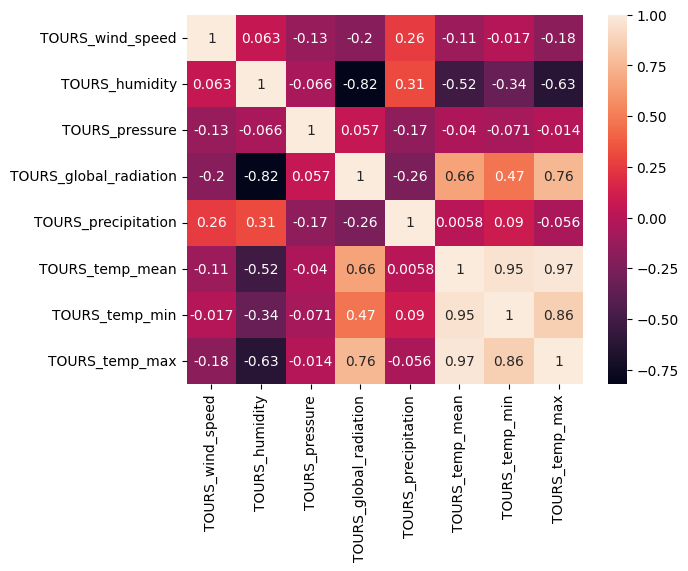

In [ ]:
ALL_THE_DATA_v = ALL_THE_DATA[['TOURS_wind_speed','TOURS_humidity','TOURS_pressure','TOURS_global_radiation','TOURS_precipitation','TOURS_temp_mean','TOURS_temp_min','TOURS_temp_max']]
corr_matrix = ALL_THE_DATA_v.corr()

# plot heat map
sns.heatmap(corr_matrix, annot=True)
pyplot.show()

## 1.2. Preprocess

### 1.2.1. Get our features

In [ ]:
DATA = ALL_THE_DATA[["DATE","TOURS_wind_speed","TOURS_humidity","TOURS_precipitation","TOURS_temp_max"]]
Date_col = DATA['DATE']
rest = DATA.drop(['DATE'], axis=1)
DATA.head()

,DATE,TOURS_wind_speed,TOURS_humidity,TOURS_precipitation,TOURS_temp_max
0,20000101,1.6,0.97,0.04,9.8
1,20000102,2.0,0.99,0.16,9.2
2,20000103,3.4,0.91,0.00,9.6
3,20000104,4.9,0.95,0.44,10.8
4,20000105,3.6,0.95,0.04,9.5


### 1.2.2. Normalization

In [ ]:
scaler = MaxAbsScaler()
scaler.fit(rest)
scaled = scaler.transform(rest)
scaled_df = pd.DataFrame(scaled, columns=rest.columns)
scaled_df.head()

,TOURS_wind_speed,TOURS_humidity,TOURS_precipitation,TOURS_temp_max
0,0.148148,0.97,0.006452,0.246231
1,0.185185,0.99,0.025806,0.231156
2,0.314815,0.91,0.000000,0.241206
3,0.453704,0.95,0.070968,0.271357
4,0.333333,0.95,0.006452,0.238693


In [ ]:
Norm_Data = pd.concat([Date_col, scaled_df], axis=1)
Norm_Data.head()

,DATE,TOURS_wind_speed,TOURS_humidity,TOURS_precipitation,TOURS_temp_max
0,20000101,0.148148,0.97,0.006452,0.246231
1,20000102,0.185185,0.99,0.025806,0.231156
2,20000103,0.314815,0.91,0.000000,0.241206
3,20000104,0.453704,0.95,0.070968,0.271357
4,20000105,0.333333,0.95,0.006452,0.238693


In [ ]:
for i in range (3654):
    Norm_Data.iat[i, 0] = str(Norm_Data.iat[i, 0])

### 1.2.3. Training and Validation

In [ ]:
Training_Data = Norm_Data[Norm_Data["DATE"].str.startswith('2000')| Norm_Data["DATE"].str.startswith('2001')| Norm_Data["DATE"].str.startswith('2002') | Norm_Data["DATE"].str.startswith('2003') | Norm_Data["DATE"].str.startswith('2004') | Norm_Data["DATE"].str.startswith('2005') | Norm_Data["DATE"].str.startswith('2006') | Norm_Data["DATE"].str.startswith('2007')]
Validation_Data = Norm_Data[Norm_Data["DATE"].str.startswith('2008')| Norm_Data["DATE"].str.startswith('2009')]


In [ ]:
Training_Data.head()

,DATE,TOURS_wind_speed,TOURS_humidity,TOURS_precipitation,TOURS_temp_max
0,20000101,0.148148,0.97,0.006452,0.246231
1,20000102,0.185185,0.99,0.025806,0.231156
2,20000103,0.314815,0.91,0.000000,0.241206
3,20000104,0.453704,0.95,0.070968,0.271357
4,20000105,0.333333,0.95,0.006452,0.238693


In [ ]:
Validation_Data.head()

,DATE,TOURS_wind_speed,TOURS_humidity,TOURS_precipitation,TOURS_temp_max
2922,20080101,0.361111,0.89,0.000000,0.113065
2923,20080102,0.481481,0.90,0.132258,0.095477
2924,20080103,0.333333,0.94,0.032258,0.178392
2925,20080104,0.481481,0.92,0.187097,0.251256
2926,20080105,0.388889,0.93,0.112903,0.273869


### 1.2.4. Data to numpy

In [ ]:
Training_Data = Training_Data.drop(['DATE',], axis=1).to_numpy()
Validation_Data = Validation_Data.drop(['DATE'], axis=1).to_numpy()

In [ ]:
print(Training_Data.shape)
print(Validation_Data.shape)

(2922, 4)
(731, 4)


# 2. THE MODELS

In [ ]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		
		end_ix = i + n_steps
		
		if end_ix > len(sequences):
			break
		
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]

		X.append(seq_x)
		y.append(seq_y)
  
	return array(X), array(y)

## 2.1. predict based on the prev week

In [ ]:
n_steps = 7

In [ ]:
X_train, y_train = split_sequences(Training_Data, n_steps)
X_val, y_val = split_sequences(Validation_Data, n_steps)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2916, 7, 3)
(2916,)
(725, 7, 3)
(725,)


### 2.1.1. RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  

Epoch 1/100
92/92 [==============================] - 3s 9ms/step - loss: 0.0607 - val_loss: 0.0471
Epoch 2/100
92/92 [==============================] - 1s 5ms/step - loss: 0.0546 - val_loss: 0.0449
Epoch 3/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0521 - val_loss: 0.0427
Epoch 4/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0499 - val_loss: 0.0403
Epoch 5/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0475 - val_loss: 0.0375
Epoch 6/100
92/92 [==============================] - 1s 5ms/step - loss: 0.0448 - val_loss: 0.0335
Epoch 7/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0417 - val_loss: 0.0280
Epoch 8/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0381 - val_loss: 0.0236
Epoch 9/100
92/92 [==============================] - 1s 5ms/step - loss: 0.0336 - val_loss: 0.0184
Epoch 10/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0285 - val_loss: 0.0163
Epoch 11/

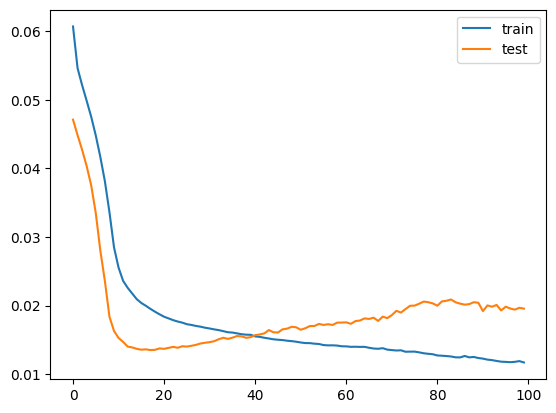

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

23/23 [==============================] - 0s 2ms/step - loss: 0.0196
0.01956234686076641


### 2.1.2. GRU

In [ ]:
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(GRU(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  

Epoch 1/100
92/92 [==============================] - 4s 14ms/step - loss: 0.0593 - val_loss: 0.0425
Epoch 2/100
92/92 [==============================] - 1s 10ms/step - loss: 0.0488 - val_loss: 0.0403
Epoch 3/100
92/92 [==============================] - 1s 10ms/step - loss: 0.0464 - val_loss: 0.0382
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.0440 - val_loss: 0.0358
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.0415 - val_loss: 0.0318
Epoch 6/100
92/92 [==============================] - 2s 17ms/step - loss: 0.0383 - val_loss: 0.0278
Epoch 7/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0337 - val_loss: 0.0197
Epoch 8/100
92/92 [==============================] - 1s 10ms/step - loss: 0.0290 - val_loss: 0.0158
Epoch 9/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0256 - val_loss: 0.0148
Epoch 10/100
92/92 [==============================] - 1s 10ms/step - loss: 0.0239 - val_loss: 0.0145

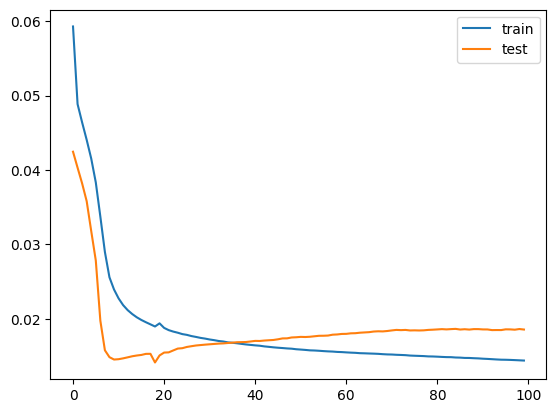

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

23/23 [==============================] - 0s 4ms/step - loss: 0.0185
0.018544737249612808


### 2.1.3. LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  


Epoch 1/100
92/92 [==============================] - 6s 22ms/step - loss: 0.0648 - val_loss: 0.0442
Epoch 2/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0506 - val_loss: 0.0418
Epoch 3/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0479 - val_loss: 0.0400
Epoch 4/100
92/92 [==============================] - 2s 22ms/step - loss: 0.0458 - val_loss: 0.0384
Epoch 5/100
92/92 [==============================] - 1s 12ms/step - loss: 0.0440 - val_loss: 0.0367
Epoch 6/100
92/92 [==============================] - 1s 12ms/step - loss: 0.0421 - val_loss: 0.0348
Epoch 7/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0396 - val_loss: 0.0322
Epoch 8/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0365 - val_loss: 0.0281
Epoch 9/100
92/92 [==============================] - 2s 17ms/step - loss: 0.0326 - val_loss: 0.0217
Epoch 10/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0294 - val_loss: 0.0188

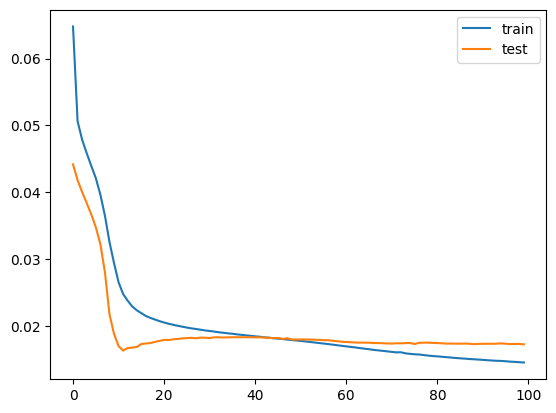

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

23/23 [==============================] - 0s 3ms/step - loss: 0.0172
0.01723298989236355


## 2.2. Predict based on the prev month

In [ ]:
n_steps = 30

In [ ]:
X_train, y_train = split_sequences(Training_Data, n_steps)
X_val, y_val = split_sequences(Validation_Data, n_steps)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2893, 30, 3)
(2893,)
(702, 30, 3)
(702,)


### 2.2.1. RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  

Epoch 1/100
91/91 [==============================] - 26s 21ms/step - loss: 0.0719 - val_loss: 0.0469
Epoch 2/100
91/91 [==============================] - 2s 18ms/step - loss: 0.0543 - val_loss: 0.0445
Epoch 3/100
91/91 [==============================] - 2s 18ms/step - loss: 0.0514 - val_loss: 0.0423
Epoch 4/100
91/91 [==============================] - 2s 18ms/step - loss: 0.0489 - val_loss: 0.0402
Epoch 5/100
91/91 [==============================] - 2s 18ms/step - loss: 0.0466 - val_loss: 0.0379
Epoch 6/100
91/91 [==============================] - 2s 22ms/step - loss: 0.0442 - val_loss: 0.0350
Epoch 7/100
91/91 [==============================] - 3s 30ms/step - loss: 0.0415 - val_loss: 0.0302
Epoch 8/100
91/91 [==============================] - 2s 21ms/step - loss: 0.0384 - val_loss: 0.0247
Epoch 9/100
91/91 [==============================] - 2s 18ms/step - loss: 0.0351 - val_loss: 0.0203
Epoch 10/100
91/91 [==============================] - 2s 18ms/step - loss: 0.0299 - val_loss: 0.017

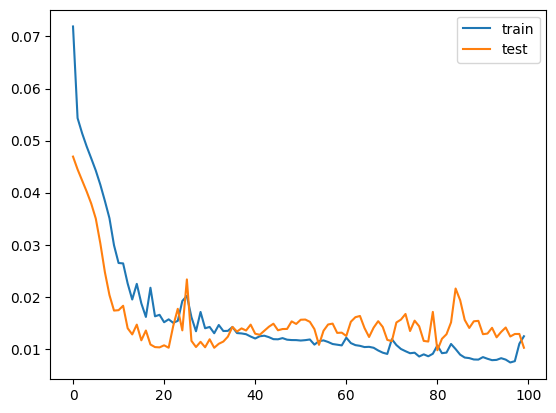

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

22/22 [==============================] - 0s 6ms/step - loss: 0.0102
0.010213207453489304


### 2.2.2. GRU

In [ ]:
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(GRU(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  

Epoch 1/100
91/91 [==============================] - 7s 42ms/step - loss: 0.0615 - val_loss: 0.0425
Epoch 2/100
91/91 [==============================] - 5s 56ms/step - loss: 0.0480 - val_loss: 0.0407
Epoch 3/100
91/91 [==============================] - 3s 35ms/step - loss: 0.0460 - val_loss: 0.0390
Epoch 4/100
91/91 [==============================] - 3s 35ms/step - loss: 0.0441 - val_loss: 0.0369
Epoch 5/100
91/91 [==============================] - 3s 38ms/step - loss: 0.0419 - val_loss: 0.0350
Epoch 6/100
91/91 [==============================] - 5s 53ms/step - loss: 0.0393 - val_loss: 0.0326
Epoch 7/100
91/91 [==============================] - 3s 37ms/step - loss: 0.0360 - val_loss: 0.0293
Epoch 8/100
91/91 [==============================] - 3s 37ms/step - loss: 0.0316 - val_loss: 0.0200
Epoch 9/100
91/91 [==============================] - 4s 44ms/step - loss: 0.0261 - val_loss: 0.0174
Epoch 10/100
91/91 [==============================] - 4s 48ms/step - loss: 0.0238 - val_loss: 0.0143

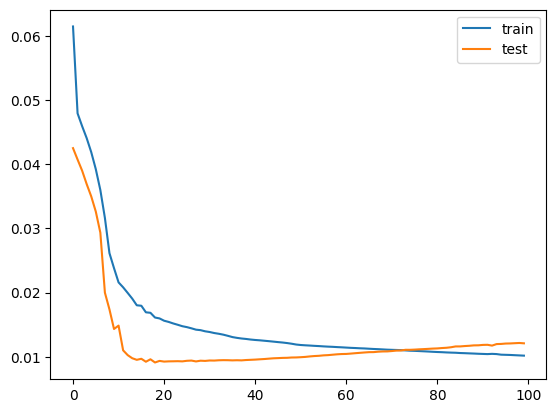

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

22/22 [==============================] - 0s 9ms/step - loss: 0.0121
0.012086059898138046


### 2.2.3. LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  


Epoch 1/100
91/91 [==============================] - 6s 37ms/step - loss: 0.0681 - val_loss: 0.0431
Epoch 2/100
91/91 [==============================] - 3s 34ms/step - loss: 0.0489 - val_loss: 0.0406
Epoch 3/100
91/91 [==============================] - 4s 48ms/step - loss: 0.0462 - val_loss: 0.0383
Epoch 4/100
91/91 [==============================] - 3s 32ms/step - loss: 0.0439 - val_loss: 0.0355
Epoch 5/100
91/91 [==============================] - 3s 32ms/step - loss: 0.0414 - val_loss: 0.0288
Epoch 6/100
91/91 [==============================] - 3s 32ms/step - loss: 0.0375 - val_loss: 0.0174
Epoch 7/100
91/91 [==============================] - 5s 50ms/step - loss: 0.0338 - val_loss: 0.0131
Epoch 8/100
91/91 [==============================] - 3s 33ms/step - loss: 0.0263 - val_loss: 0.0164
Epoch 9/100
91/91 [==============================] - 3s 32ms/step - loss: 0.0222 - val_loss: 0.0137
Epoch 10/100
91/91 [==============================] - 3s 32ms/step - loss: 0.0198 - val_loss: 0.0113

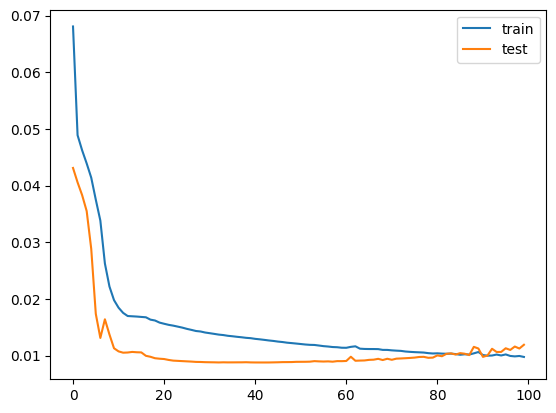

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

22/22 [==============================] - 0s 14ms/step - loss: 0.0119
0.011923715472221375


## 2.3. Predict based on the prev 4 months

In [ ]:
n_steps = 30*4

In [ ]:
X_train, y_train = split_sequences(Training_Data, n_steps)
X_val, y_val = split_sequences(Validation_Data, n_steps)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2803, 120, 3)
(2803,)
(612, 120, 3)
(612,)


### 2.3.1. RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  

Epoch 1/100
88/88 [==============================] - 8s 58ms/step - loss: 0.0714 - val_loss: 0.0506
Epoch 2/100
88/88 [==============================] - 5s 56ms/step - loss: 0.0546 - val_loss: 0.0475
Epoch 3/100
88/88 [==============================] - 6s 69ms/step - loss: 0.0519 - val_loss: 0.0448
Epoch 4/100
88/88 [==============================] - 4s 51ms/step - loss: 0.0493 - val_loss: 0.0416
Epoch 5/100
88/88 [==============================] - 5s 62ms/step - loss: 0.0468 - val_loss: 0.0380
Epoch 6/100
88/88 [==============================] - 5s 61ms/step - loss: 0.0436 - val_loss: 0.0331
Epoch 7/100
88/88 [==============================] - 4s 50ms/step - loss: 0.0404 - val_loss: 0.0265
Epoch 8/100
88/88 [==============================] - 6s 69ms/step - loss: 0.0347 - val_loss: 0.0209
Epoch 9/100
88/88 [==============================] - 5s 54ms/step - loss: 0.0267 - val_loss: 0.0273
Epoch 10/100
88/88 [==============================] - 4s 50ms/step - loss: 0.0344 - val_loss: 0.0212

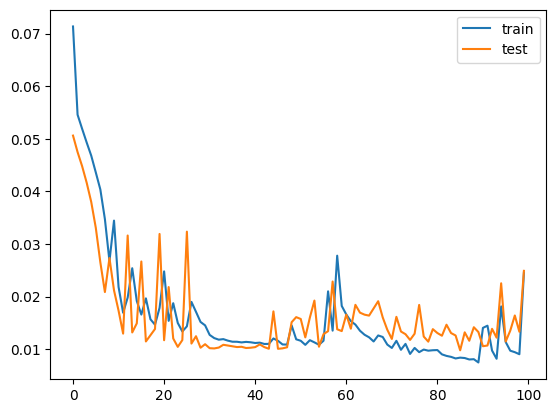

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

20/20 [==============================] - 0s 13ms/step - loss: 0.0249
0.024893641471862793


### 2.3.2. GRU

In [ ]:
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(GRU(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  

Epoch 1/100
88/88 [==============================] - 15s 137ms/step - loss: 0.0653 - val_loss: 0.0458
Epoch 2/100
88/88 [==============================] - 12s 134ms/step - loss: 0.0498 - val_loss: 0.0441
Epoch 3/100
88/88 [==============================] - 12s 133ms/step - loss: 0.0479 - val_loss: 0.0424
Epoch 4/100
88/88 [==============================] - 11s 129ms/step - loss: 0.0462 - val_loss: 0.0407
Epoch 5/100
88/88 [==============================] - 10s 118ms/step - loss: 0.0442 - val_loss: 0.0388
Epoch 6/100
88/88 [==============================] - 12s 135ms/step - loss: 0.0423 - val_loss: 0.0364
Epoch 7/100
88/88 [==============================] - 12s 134ms/step - loss: 0.0399 - val_loss: 0.0339
Epoch 8/100
88/88 [==============================] - 12s 134ms/step - loss: 0.0370 - val_loss: 0.0319
Epoch 9/100
88/88 [==============================] - 12s 133ms/step - loss: 0.0333 - val_loss: 0.0282
Epoch 10/100
88/88 [==============================] - 10s 116ms/step - loss: 0.026

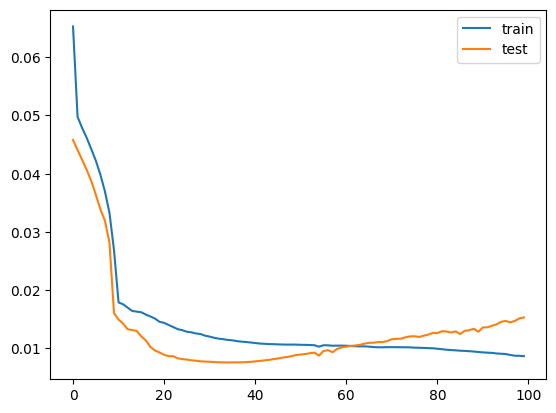

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

20/20 [==============================] - 0s 24ms/step - loss: 0.0153
0.015329571440815926


### 2.3.3. LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 3)))
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False)  


Epoch 1/100
88/88 [==============================] - 18s 154ms/step - loss: 0.0720 - val_loss: 0.0481
Epoch 2/100
88/88 [==============================] - 13s 148ms/step - loss: 0.0515 - val_loss: 0.0452
Epoch 3/100
88/88 [==============================] - 13s 151ms/step - loss: 0.0489 - val_loss: 0.0433
Epoch 4/100
88/88 [==============================] - 13s 151ms/step - loss: 0.0470 - val_loss: 0.0417
Epoch 5/100
88/88 [==============================] - 13s 152ms/step - loss: 0.0454 - val_loss: 0.0401
Epoch 6/100
88/88 [==============================] - 14s 154ms/step - loss: 0.0440 - val_loss: 0.0385
Epoch 7/100
88/88 [==============================] - 14s 155ms/step - loss: 0.0424 - val_loss: 0.0356
Epoch 8/100
88/88 [==============================] - 14s 155ms/step - loss: 0.0395 - val_loss: 0.0271
Epoch 9/100
88/88 [==============================] - 14s 154ms/step - loss: 0.0299 - val_loss: 0.0113
Epoch 10/100
88/88 [==============================] - 14s 155ms/step - loss: 0.025

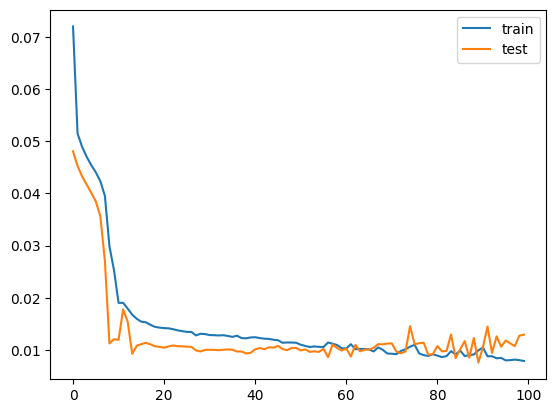

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
loss = model.evaluate(X_val, y_val)

print(loss)

20/20 [==============================] - 1s 37ms/step - loss: 0.0130
0.012950765900313854


# 3. Performance

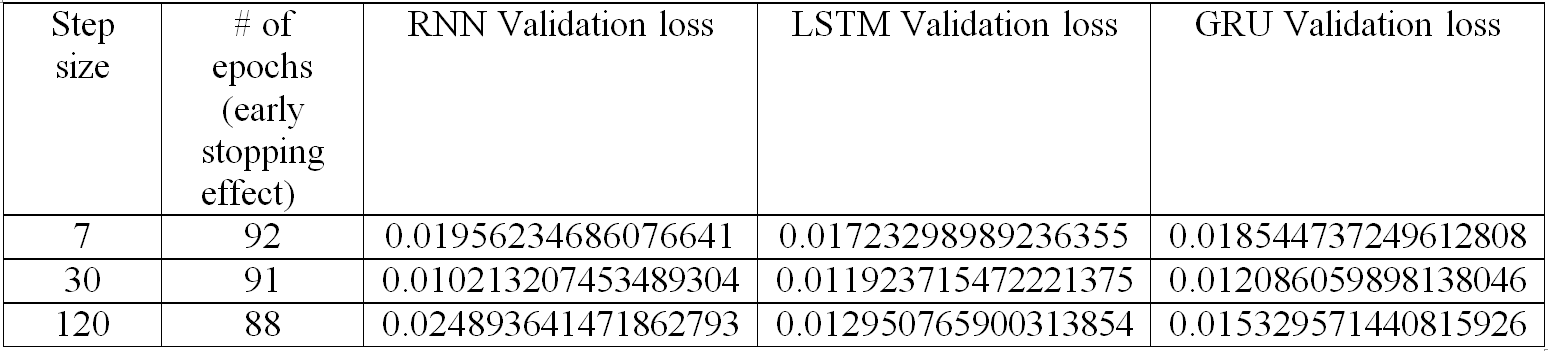

- **The best performace is** : *RNN* with 30 steps
- **The worst performance is** : *RNN* with 120 steps (because it suffers Gradient vanishing with long term sequence)
- **The best sequence length is** *30 steps* so we can predict the temperature based on the previous month observation
- **early stopping** monitor the *val los* so it prevent the model from overfitting